<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/SIRS_Metapopulation_With_Reporting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
np.random.seed(2070778)
random.seed(2070778)

This project simulates the spread of an infectious disease using a spatial SIRS (Susceptible–Infected–Recovered–Susceptible) model across a some number of regions (currently set to 3) over one year. The model includes daily mobility between regions, with infections, recoveries, and waning immunity modeled stochastically using binomial sampling. To simulate outbreak events, each region has a predefined day when its transmission rate (beta) increases from a baseline to a higher value, with both the timing and magnitude varying by region. To mimic real-world reporting behavior, the simulation applies binomial underreporting, with reporting rates doubled on weekends compared to weekdays. Additionally, reporting rates are higher during outbreak periods than during non-outbreak period. The resulting data are exported as a CSV file for testing outbreak detection algorithms.

In [3]:
def mobility(stat_matrix, max_move):
    stat = stat_matrix.flatten().astype(int)

    if np.all(stat >=1): # Only if the values in the compartment/status are not 0, and there are poeple to move
      R = stat.size

      # Pick a random number to represent the number of people being moved
      losses = np.random.randint(0, stat, size=R)
      total_loss = losses.sum()
      if total_loss > max_move: # Cap on number people that can move
          losses = np.floor(losses * (max_move / total_loss)).astype(int)
          total_loss = losses.sum()

      # Redistribute those movers as gains (Total People emigrate = Total People Immigrate)
      gains = np.random.multinomial(total_loss, [1/R]*R)

      # Apply the change to the population data and doing sanity check to have the population conservation and not to make a region have 0 person
      delta = gains - losses
      assert delta.sum() == 0, "Population not conserved"
      assert np.all(stat + delta >= 1), "Some region dropped below 1"
      return stat + delta

    else:
      return stat


In [4]:
def reporting_dynamic(true_cases, t, r, reporting_delay, reporting_rate, days, use_delay=True):
    """
    true_cases (int): Number of actual new cases.
    t (int): Current day.
    r (int): Region index.
    reporting_delay (array): Delay matrix (regions x days).
    reporting_rate (float): Base reporting rate (e.g., 0.6).
    days (int): Total number of days in simulation.
    """
    weekday = t % 7 # Indexing the date as days
    rate = reporting_rate * (1.0 if weekday in [5, 6] else 0.5) # Weekend reports are doubles of that in weekday
    reported = np.random.binomial(n=int(true_cases), p=rate) # The report are modelled by binomial

    delay = reporting_delay[r, t] if use_delay else 0 # If i want to make a delay (just in case)
    report_day = t + delay # Then the report will be delayed

    if report_day < days:
        return report_day, reported
    else:
        return None, 0 # Stop when outside the simulated day range

In [5]:
## Parameters
# SIRS
regions = 3                         # Number of spatial regions
N_current = [10000,10000,10000]     # Population per region
beta_outbreak = [0.22, 0.23, 0.2]     # Infection rate that causes outbreak
beta_low = [0.15, 0.15, 0.14]          # Infection rate without outbreak
gamma = 0.08                       # Recovery rate
waning_rate = 0.005             # Rate of losing immunity and back being susceptible
days = 2000                         # Duration of simulation
initial_infected = [10, 10, 10]     # Initial infected per region
initial_recovered = [5, 5, 5]       # Initial recovered per region

# Beta schedulling
start_outbreak_day = [100, 100, 100]
high_beta_duration = [90,90,90]    # How long beta high stays (days)
low_beta_duration = [210,210,210]  # How long beta low stays (days)


# For each region: mode (True=high, False=low), and timer for current mode
mode_high = [False] * regions
mode_timer = start_outbreak_day    # match start_outbreak_day for the start of the outbreak
true_outbreak_label = np.zeros((regions, days), dtype=int)

# Moving
max_ppl_move = 100                  # Cap on how many people can move (might be useful if we want to simulate social distancing)


# Reporting
reporting_rate_array = [0.8, 0.8, 0.8]  # Reporting rate per region
reported_cases = np.zeros((regions, days)) # Initialization for the reported cases array

# If i want the delay
max_delay = 3             # cap reporting delay
delay_dist = np.random.poisson
reporting_delay = np.minimum(delay_dist(2, size=(regions, days)), max_delay)


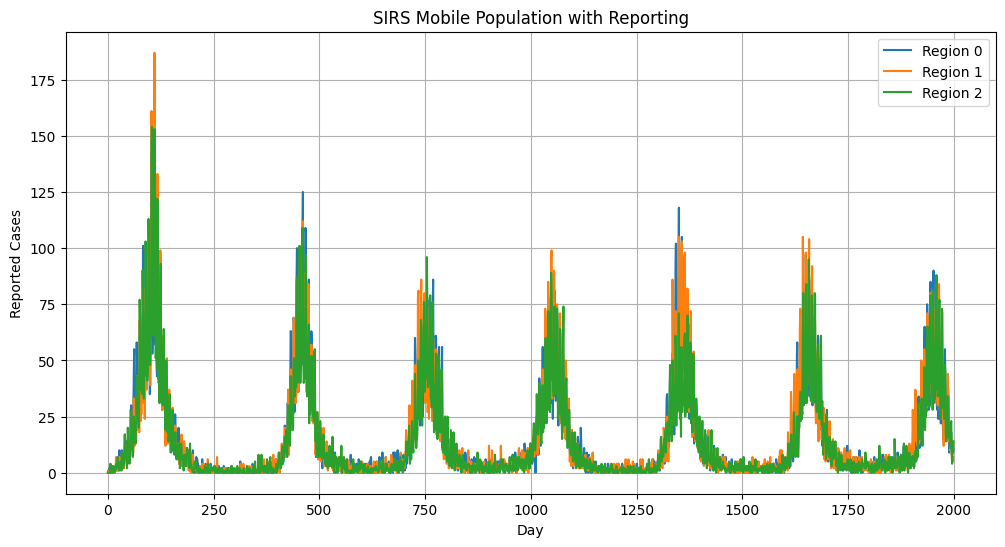

In [6]:
# Initialize SIR arrays
S = np.zeros((regions, days))
I = np.zeros((regions, days))
R = np.zeros((regions, days))
for r in range(regions):
    S[r, 0] =  N_current[r] - initial_infected[r] - initial_recovered[r]
    I[r, 0] = initial_infected[r]
    R[r, 0] = initial_recovered[r]


for t in range(1, days):
    for r in range(regions):

       #1. Disease simulation (normal days and outbreak)

       ## Beta scheduling
        # Start high-beta if today is an outbreak day for region r
        if mode_timer[r] == 0:
          # Switch mode
          mode_high[r] = not mode_high[r]  # Toggle between high and low
          if mode_high[r]:
              mode_timer[r] = high_beta_duration[r]
          else:
              mode_timer[r] = low_beta_duration[r]

        # Set beta depending on mode
        beta = beta_outbreak[r] if mode_high[r] else beta_low[r]
        mode_timer[r] -= 1

        true_outbreak_label[r, t] = int(mode_high[r])


        # SIRS dynamics
        # Infection
        p_infect = beta * (I[r, t-1] / N_current[r])
        if p_infect>=1:
          print ("something wrong in the p infection")
        new_infected = np.random.binomial(n=int(S[r, t-1]), p=p_infect)

        # Recovery
        new_recovered = np.random.binomial(n=int(I[r, t-1]), p=gamma)

        # Back to susceptible
        new_susceptible = np.random.binomial(n=int(R[r, t-1]), p=waning_rate)


        S[r, t] = S[r, t-1] - new_infected + new_susceptible
        I[r, t] = I[r, t-1] + new_infected - new_recovered
        R[r, t] = R[r, t-1] + new_recovered - new_susceptible


        #2. Reporting
        reporting_rate = reporting_rate_array[r] # Begin with low report since there is no outbreak

        report_day, reported = reporting_dynamic(
            true_cases=new_infected,
            t=t,
            r=r,
            reporting_delay=reporting_delay,
            reporting_rate=reporting_rate,
            days=days,
            use_delay=False  #false for instant reporting
        )

        if report_day is not None:
            reported_cases[r, report_day] += reported


    #3. Mobility
    S[:, t] = mobility(S[:, t], max_ppl_move)
    I[:, t] = mobility(I[:, t], max_ppl_move)
    R[:, t] = mobility(R[:, t], max_ppl_move)
    N_current = S[:, t] + I[:, t] + R[:, t] # Update the number of population after the mobility



# Compile results
data = pd.DataFrame([
    {'Day': t, 'Region': r,
     'Susceptible': S[r, t], 'Infected': I[r, t],
     'Recovered': R[r, t], 'Reported Cases': reported_cases[r, t], 'True Outbreak': true_outbreak_label[r, t]}
    for r in range(regions) for t in range(days)
])

# Plot reported cases over time for each region
plt.figure(figsize=(12, 6))
for r in range(regions):
    subset = data[data['Region'] == r]
    plt.plot(subset['Day'], subset['Reported Cases'], label=f'Region {r}')
plt.xlabel('Day')
plt.ylabel('Reported Cases')
plt.title('SIRS Mobile Population with Reporting')
plt.legend()
plt.grid(True)
plt.show()

## Saving in the Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# import os
# os.makedirs("/content/drive/MyDrive/satscan_data", exist_ok=True)

In [9]:
output_path = "/content/drive/MyDrive/satscan_data/simulation_data(2000 days).csv"
data.to_csv(output_path, index=False)